# Analizamos los datos que tenemos assignados

In [6]:
import pandas as pd

input_path = '../data/grupos_ubicacio_merged.csv'
data = pd.read_csv(input_path)

data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_GRUPO                515 non-null    object 
 1   ID_FECHA_GRUPO          515 non-null    object 
 2   ID_HORA_INICIO          515 non-null    object 
 3   ID_HORA_FIN             515 non-null    object 
 4   ID_CURSO_ACADEMICO      515 non-null    int64  
 5   ID_ASIGNATURA           515 non-null    int64  
 6   ID_TIPO_DOCENCIA        515 non-null    int64  
 7   ID_COD_GRUPO            515 non-null    int64  
 8   ID_PERIODO_DOCENTE      515 non-null    int64  
 9   IND_ALUMNOS_GRUPO_PREV  515 non-null    int64  
 10  IND_ALUMNOS_GRUPO_REAL  515 non-null    int64  
 11  IND_HORAS_PREVISTAS     515 non-null    float64
 12  AULA_ASIGNADA           515 non-null    object 
 13  DS_UBICACIO             515 non-null    object 
 14  ID_EDIFICI              515 non-null    ob

(                  ID_GRUPO ID_FECHA_GRUPO ID_HORA_INICIO ID_HORA_FIN  \
 0   2024-0-115-102714-1-31     2025-03-10       11:30:00    13:30:00   
 1   2024-0-115-102690-1-31     2025-03-10       08:30:00    10:30:00   
 2   2024-0-115-106050-1-21     2025-03-10       10:30:00    11:30:00   
 3  2024-0-115-102757-1-450     2025-03-10       11:30:00    13:30:00   
 4   2024-0-115-106048-1-21     2025-03-10       13:30:00    14:30:00   
 
    ID_CURSO_ACADEMICO  ID_ASIGNATURA  ID_TIPO_DOCENCIA  ID_COD_GRUPO  \
 0                2024         102714                 1            31   
 1                2024         102690                 1            31   
 2                2024         106050                 1            21   
 3                2024         102757                 1           450   
 4                2024         106048                 1            21   
 
    ID_PERIODO_DOCENTE  IND_ALUMNOS_GRUPO_PREV  IND_ALUMNOS_GRUPO_REAL  \
 0                   1                     158

# Calculo Ocupación

Hacemos un indice que compara la ocupacion de las ubicaciones con las reales, mostramos una tabla de ocupación de las diferentes horas.

In [7]:
data['ID_FECHA_GRUPO'] = pd.to_datetime(data['ID_FECHA_GRUPO'])
data['ID_HORA_INICIO'] = pd.to_datetime(data['ID_HORA_INICIO'], format='%H:%M:%S').dt.time
data['ID_HORA_FIN'] = pd.to_datetime(data['ID_HORA_FIN'], format='%H:%M:%S').dt.time

data['Ocupacion'] = (data['IND_ALUMNOS_GRUPO_REAL'] / data['CAPACIDAD']) * 100

data['DayOfWeek'] = data['ID_FECHA_GRUPO'].dt.day_name()
data['TimeSlot'] = pd.cut(pd.to_datetime(data['ID_HORA_INICIO'].astype(str)).dt.hour, 
                          bins=[0, 8, 12, 16, 20, 24], 
                          labels=["Night", "Morning", "Afternoon", "Evening", "Late Night"], 
                          right=False)

occupancy_by_day_time = data.groupby(['DayOfWeek', 'TimeSlot']).Ocupacion.mean().unstack()

occupancy_by_day_time

/tmp/ipykernel_156312/2125944659.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['TimeSlot'] = pd.cut(pd.to_datetime(data['ID_HORA_INICIO'].astype(str)).dt.hour,
/tmp/ipykernel_156312/2125944659.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  occupancy_by_day_time = data.groupby(['DayOfWeek', 'TimeSlot']).Ocupacion.mean().unstack()


TimeSlot,Night,Morning,Afternoon,Evening,Late Night
DayOfWeek,,,,,
Friday,NaN,74.983059,71.733004,62.996985,NaN
Monday,NaN,77.856230,73.905382,71.656574,NaN
Thursday,NaN,77.860326,75.239119,61.458253,NaN
Tuesday,NaN,83.394003,72.974982,66.578802,NaN
Wednesday,NaN,78.508975,81.449799,69.779901,41.833239


Para finalizar mostramos un mapa de calor de la ocupabilidad de las aulas en la semana que hemos analizado.

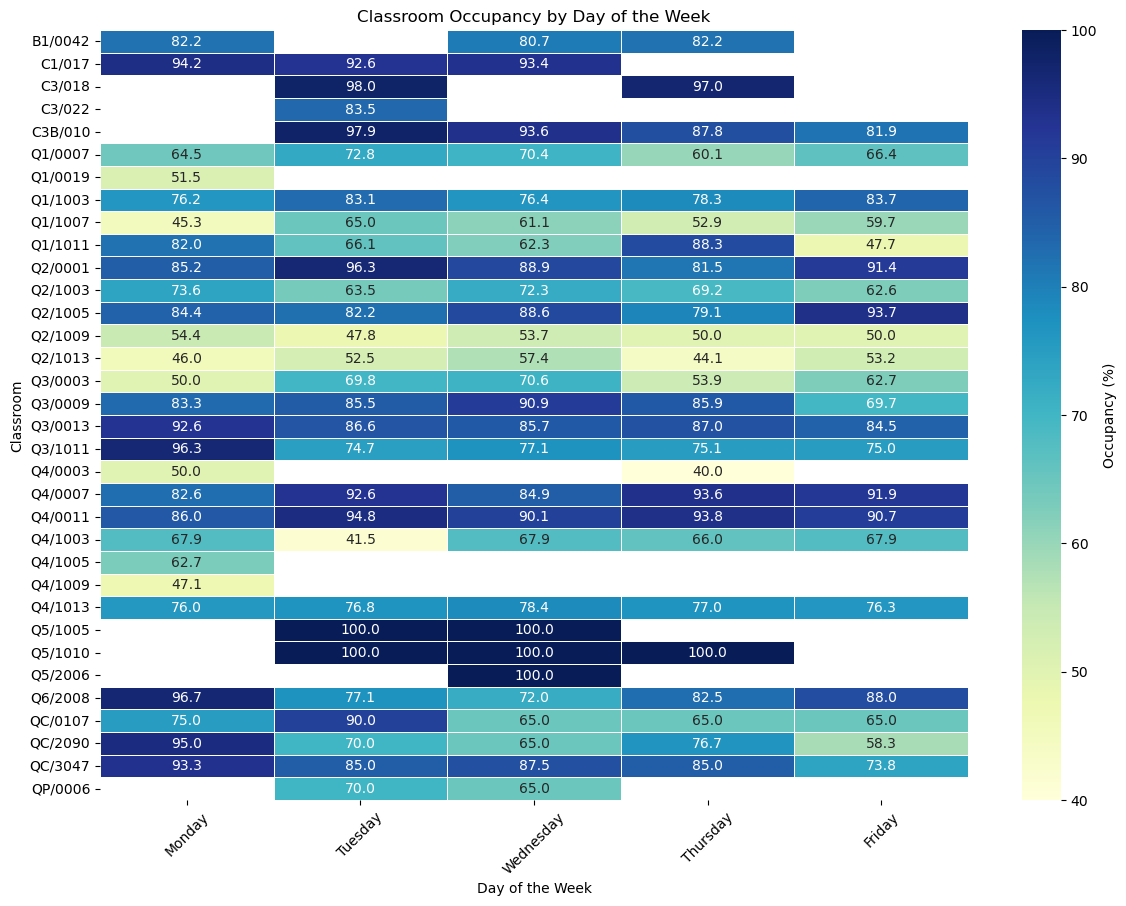

In [15]:
input_path = '../data/ubicaciones_cleaned.csv'
ubicaciones_data = pd.read_csv(input_path)

data['ID_FECHA_GRUPO'] = pd.to_datetime(data['ID_FECHA_GRUPO'])
data['DayOfWeek'] = data['ID_FECHA_GRUPO'].dt.day_name()

data['Ocupacion'] = (data['IND_ALUMNOS_GRUPO_REAL'] / data['CAPACIDAD']) * 100

occupancy_heatmap_data = data.pivot_table(index='AULA_ASIGNADA', columns='DayOfWeek', values='Ocupacion', aggfunc='mean')

occupancy_heatmap_data = occupancy_heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(occupancy_heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Occupancy (%)'})
plt.title("Classroom Occupancy by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Classroom")
plt.xticks(rotation=45)
plt.show()